# Insurance All

## Business Problem

Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: auto insurance.

As with health insurance, customers of this new auto insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, aimed at the costs of an eventual accident or damage to the vehicle.

Insurance All conducted a survey of about 380,000 customers about their interest in joining a new auto insurance product last year. All customers expressed interest or not in purchasing auto insurance and these responses were saved in a database along with other customer attributes.

The product team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, in which they will receive the offer of the new auto insurance product. The offer will be made by the sales team through telephone calls.

However, the sales team has the capacity to make 20 thousand calls within the campaign period.

The challenge
In that context, it is necessary build a model that predicts whether or not the customer would be interested in auto insurance.

With its solution, the sales team hopes to be able to prioritize the people with the greatest interest in the new product and optimize the campaign by making only contacts with customers most likely to make the purchase.

As a result of the project, it is needed to deliver a report containing some analysis and answers to the following questions:

- Main Insights about the most relevant attributes of customers interested in purchasing auto insurance.

- What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?

- And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

- How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

## Data Base Credentials

- Database: Postgres 12.0 - AWS
- Credentials:
- HOST = comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com
- PORT=5432
- Database=comunidadedsdb
- Username=member
- Password=cdspa
- Presentation of PA004: https://docs.google.com/presentation/d/1gMo5xFPSvAEWsFGHyZKgLLQwzvg2lc65BSXuaLLmWyg/edit?usp=sharing
- Link for business probelm: https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

# Imports

In [1]:
# databse conmection
import psycopg2
from psycopg2 import OperationalError
import pandas.io.sql as psql

# data manipulation
import pandas as pd

# statistics
import statistics as st

# data visualization
from matplotlib import pyplot as plt
import seaborn  as sns

# data analysis
from pandas_profiling import ProfileReport

# data encoding
from sklearn.preprocessing import OneHotEncoder

# data reescaling
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler 

# data balancing
from imblearn.combine import SMOTETomek

# split dataset
from sklearn.model_selection import train_test_split

# Feature Selection
from boruta import BorutaPy

# machine learning
from sklearn.dummy          import DummyClassifier
from xgboost                import XGBClassifier
from sklearn.ensemble       import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.linear_model   import LogisticRegression, SGDClassifier
from lightgbm               import LGBMClassifier
from sklearn.naive_bayes    import GaussianNB
from imblearn.ensemble      import BalancedRandomForestClassifier
from catboost               import CatBoostClassifier

# metrics
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.metrics    import top_k_accuracy_score

#fine tuning
from skopt                   import forest_minimize
from sklearn.model_selection import GridSearchCV
from skopt                   import BayesSearchCV

# calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# cross validation
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# display
from IPython.core.display import HTML
from IPython.display      import Image

# save pickle objects
import pickle

# filter warnings
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
###########################################################################################################################

# Descripite Statistics of a Data Frame
def descriptive( df ):
    # Central Tendency - mean, median, mode 
    ct1 = pd.DataFrame( df.apply( np.mean) ).T
    ct2 = pd.DataFrame( df.apply( np.median) ).T
    ct3 = pd.DataFrame( df.apply( st.mode ) ).T 
    
    # Dispersion
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .25))).T
    d6 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .75))).T
    d7 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d8 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4, d5, d6, d7, d8]).T.reset_index()
    ds.columns = ['attributes', 'mean', 'median', 'mode', 'std', 'min', 'max', 'range', 'Q1', 'Q3', 'skewness', 'kurtosis']
    return ds

###########################################################################################################################

# Feature Selection
def feature_selection(model, x, y,):
    model.fit(x, y)
        
    # Feature importance data frame
    feat_imp = pd.DataFrame({'feature': x.columns,
                             'feature_importance': model.feature_importances_}) \
                             .sort_values('feature_importance', ascending=False) \
                             .reset_index(drop=True)
        
    # Plot feature importance
    plt.figure(figsize=(12,6))
    sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', palette='magma')
    plt.title(type(model).__name__, size=16)
    plt.yticks(size=13)
    plt.xticks(size=13)
    plt.xlabel('Feature Importance', size=16, color='grey')
    plt.ylabel('Features', size=16, color='grey')
    
###########################################################################################################################

# Precision @ K
def precision_at_k( data, k=20000 ):
   
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 
    
    # calculate precision @ k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

###########################################################################################################################

# Recall @ K
def recall_at_k( data, k=20000 ):
   
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    # calculate recall @ k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

###########################################################################################################################

# Metrics @ k
def metrics_at_k (data, model, x_train, y_train, x_val, y_val):
    model_df = []     
    
    for model in model:
        print("Training " + type(model).__name__ + "...")
        model.fit(x_train, y_train)

        # probabilities prediction
        yhat = model.predict_proba(x_val)

        # copy data
        data = x_val.copy()
        data['response'] = y_val.copy()

        # propensity score
        data['score'] = yhat[:, 1].tolist()

        # sorte clients by propensity score
        data = data.sort_values('score', ascending=False)

        # compute precision at k
        precision = precision_at_k(data)

        # compute recall at k
        recall = recall_at_k(data)

        df = pd.DataFrame({'Model Name': type(model).__name__,'Precision@K': precision, 
                           'Recall@K': recall}, index = [0]).sort_values('Precision@K', ascending = False)

        model_df.append(df)
        final_model = pd.concat(model_df)
    return final_model.sort_values(by='Precision@K', ascending=False).round(5)

###########################################################################################################################

# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = [12,6]
    plt.rcParams['font.size'] = 16
    #display( HTML( '<style>.container { width: 80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()
    
###########################################################################################################################

Populating the interactive namespace from numpy and matplotlib


# Load Dataset - SQL

In [29]:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
user = 'member'
pwd = 'cdspa'

## Check Database

In [30]:
# Connect to an existing dataset
conn = psycopg2.connect(user = user,
               password = pwd,
               host = host,
               port = port,
               database = database)

## Check Schemas

In [31]:
# Create a cursor to perfor database operations
cursor = conn.cursor()

# Take a look at Schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""
cursor.execute( query_schema )

record = cursor.fetchall()
print( record )

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',)]


## Select pa004 tables

In [32]:
# Create a cursor to perfor database operations
cursor = conn.cursor()

# Take a look at Schemas
query_tables = """
    SELECT tablename
    FROM  pg_tables
    WHERE schemaname='pa004'
"""
cursor.execute( query_tables )

record = cursor.fetchall()
print( record )

[('users',), ('vehicle',), ('insurance',)]


## Check Tables

In [3]:
# import the tables
df_users = pd.read_sql("SELECT * FROM pa004.users", con=conn)
df_vehicle = pd.read_sql("SELECT * FROM pa004.vehicle", con=conn)
df_insurance = pd.read_sql("SELECT * FROM pa004.insurance", con=conn)

NameError: name 'conn' is not defined

In [34]:
# show users dataset
df_users

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.00000,26.00000
1,2,Male,76,3.00000,26.00000
2,3,Male,47,28.00000,26.00000
3,4,Male,21,11.00000,152.00000
4,5,Female,29,41.00000,152.00000
...,...,...,...,...,...
381104,381105,Male,74,26.00000,26.00000
381105,381106,Male,30,37.00000,152.00000
381106,381107,Male,21,30.00000,160.00000
381107,381108,Female,68,14.00000,124.00000


In [35]:
# show vehicle dataset
df_vehicle

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No
...,...,...,...,...
381104,381105,1,1-2 Year,No
381105,381106,1,< 1 Year,No
381106,381107,1,< 1 Year,No
381107,381108,1,> 2 Years,Yes


In [36]:
# show insurance dataset
df_insurance

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.00000,217,1
1,2,0,33536.00000,183,0
2,3,0,38294.00000,27,1
3,4,1,28619.00000,203,0
4,5,1,27496.00000,39,0
...,...,...,...,...,...
381104,381105,1,30170.00000,88,0
381105,381106,1,40016.00000,131,0
381106,381107,1,35118.00000,161,0
381107,381108,0,44617.00000,74,0


## Raw Data

In [37]:
# merge all datasets
df_raw = pd.merge( df_users, df_vehicle, how='inner', on='id' )
df_raw = pd.merge( df_raw, df_insurance, how='inner', on='id' )

In [38]:
# see the dataset
df_raw

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.00000,26.00000,1,> 2 Years,Yes,0,40454.00000,217,1
1,2,Male,76,3.00000,26.00000,1,1-2 Year,No,0,33536.00000,183,0
2,3,Male,47,28.00000,26.00000,1,> 2 Years,Yes,0,38294.00000,27,1
3,4,Male,21,11.00000,152.00000,1,< 1 Year,No,1,28619.00000,203,0
4,5,Female,29,41.00000,152.00000,1,< 1 Year,No,1,27496.00000,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.00000,26.00000,1,1-2 Year,No,1,30170.00000,88,0
381105,381106,Male,30,37.00000,152.00000,1,< 1 Year,No,1,40016.00000,131,0
381106,381107,Male,21,30.00000,160.00000,1,< 1 Year,No,1,35118.00000,161,0
381107,381108,Female,68,14.00000,124.00000,1,> 2 Years,Yes,0,44617.00000,74,0


In [42]:
# save the dataset
pickle.dump(df_raw, open('/home/andre/Insync/pa004_health_insurance_cross_sell/data/df_raw.pkl', 'wb'))

In [43]:
# empty auxiliary datasets
df_insurance = None
df_users = None
df_vehicle = None

# Raw Dataset Analysis

#### Dataset Columns

- Id: Customer ID
- Gender: Customer Gender 
- Customer Age: Customer Age
- Region Code: The code of the region that customer lives
- Policy Sales Channel: The code for the customer disclosure channel (mail, phone, agents, etc.)
- Driving License: Customer has a license 1; customer has no license 0
- Vehicle Age: The age of the vehicle
- Vehicle Damage: If the vehicle has been damaged in the past, yes or no
- Previously Insured: If the customer has a previous insurance, no: 0, yes: 1
- Annual Premium: How much the customer paid the company for annual health insurance
- Vintage: Number of days the customer joined the company through the purchase of health insurance.
- Response: The customer has interest in buy the car insurance, no: 0, yes: 1

#### The dataset has 381109 rows × 12 columns

In [ ]:
profile = ProfileReport(df_raw, title='Insurance_All') profile.to_file(output_file='Insurance_All')

# Strings to Numerical Columns

In [ ]:
df1 = pickle.load(open('data/df_raw.pkl', 'rb'))

In [4]:
# label enconding
df1["gender"] = df1["gender"].apply(lambda x: 0 if x == 'Male' else 1).astype(int)
df1["vehicle_damage"] = df1["vehicle_damage"].apply(lambda x: 0 if x == 'No' else 1).astype(int)

# ordinal enconding
df1["vehicle_age"] = df1["vehicle_age"].apply(lambda x: 0 if x == '< 1 Year' else 1 if x == '1-2 Year' else 2).astype(int)

In [5]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,0,44,28.00000,26.00000,1,2,1,0,40454.00000,217,1
1,2,0,76,3.00000,26.00000,1,1,0,0,33536.00000,183,0
2,3,0,47,28.00000,26.00000,1,2,1,0,38294.00000,27,1
3,4,0,21,11.00000,152.00000,1,0,0,1,28619.00000,203,0
4,5,1,29,41.00000,152.00000,1,0,0,1,27496.00000,39,0


In [6]:
# save dataset
pickle.dump(df1, open('data/df1.pkl', 'wb'))

## According to the Pandas Profile Report the following key points can be highlighted:

-  The data set has no missing cells or duplicate rows
-  There are more men (54.1%) than women (45.9%)
-  The age ranges from 20 to 85 years. The average age is 38 years and the distribution is positively skewed (0.67). There is a peak at the ages of 23 and 24, both representing 13.2% of all ages
-  The most common region code is 28, representing 27.9% of all 53 codes
-  The most common policy sales channel are 152 (35.4%), 26 (20.9%) and 124 (19.4%)
-  Most customers have a driver's license (99.8%)
-  Most vehicles are between 1 and 2 years old (52.6%), followed by vehicles under 1 year old (43.2%) and over 2 years old (4.2%)
-  Most vehicles were damaged (50.5%)
-  Most customers have already been assured (54.2%)
-  The average of annual premium is 30564, in addition to a minimum of 2630 and a maximum of 540165. The distribution is highly skewed (1.76) and has a kurtosis of 34, which implies that there are many outliers and data is concentrated at the beginning of the curve
-  The target variable (response) is quite unbalanced, since 87.7% of customers answered "no" to a new auto insurance proposal

# Mind Map

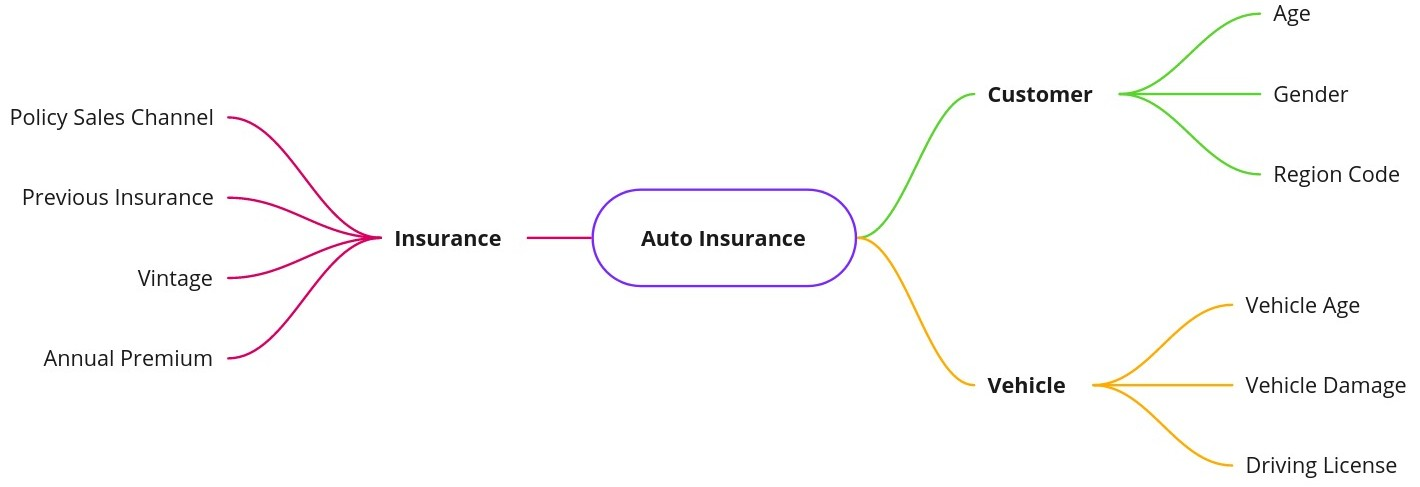

In [27]:
Image('img/mind_map.jpg')

# Feature Engineering

In [ ]:
df2 = pickle.load(open('data/df1.pkl', 'rb'))

In [17]:
# age damage
age_damage = pd.DataFrame(df2.groupby('age')['vehicle_damage'].sum()).reset_index().rename(columns={'vehicle_damage':'age_damage'})
df2 = pd.merge(df2, age_damage, how='left', on='age')

# vintage annual premium
df2['vintage_annual_premium'] = (df2['annual_premium']) / (df2['vintage'])

# age vintage
df2['age_vintage'] = (df2['age']*365) / (df2['vintage'])

# age_damage_premium
df2['age_damage_premium'] = (df2['annual_premium']) / (df2['age_damage'])

In [18]:
df2.head() 

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_damage,vintage_annual_premium,age_vintage,age_damage_premium
0,1,0,44,28.00000,26.00000,1,2,1,0,40454.00000,217,1,5771,186.42396,74.00922,7.00988
1,2,0,76,3.00000,26.00000,1,1,0,0,33536.00000,183,0,837,183.25683,151.58470,40.06691
2,3,0,47,28.00000,26.00000,1,2,1,0,38294.00000,27,1,5090,1418.29630,635.37037,7.52338
3,4,0,21,11.00000,152.00000,1,0,0,1,28619.00000,203,0,7324,140.98030,37.75862,3.90756
4,5,1,29,41.00000,152.00000,1,0,0,1,27496.00000,39,0,2504,705.02564,271.41026,10.98083


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      381109 non-null  int64  
 1   gender                  381109 non-null  int64  
 2   age                     381109 non-null  int64  
 3   region_code             381109 non-null  float64
 4   policy_sales_channel    381109 non-null  float64
 5   driving_license         381109 non-null  int64  
 6   vehicle_age             381109 non-null  int64  
 7   vehicle_damage          381109 non-null  int64  
 8   previously_insured      381109 non-null  int64  
 9   annual_premium          381109 non-null  float64
 10  vintage                 381109 non-null  int64  
 11  response                381109 non-null  int64  
 12  age_damage              381109 non-null  int64  
 13  vintage_annual_premium  381109 non-null  float64
 14  age_vintage         

In [ ]:
pickle.dump(df2, open( 'data/df2.pkl', 'wb' ) )

# Exploratory Data Analysis - Insight Generation

In [91]:
df3 = pickle.load(open('data/df2.pkl', 'rb'))

## Univariate Analysis

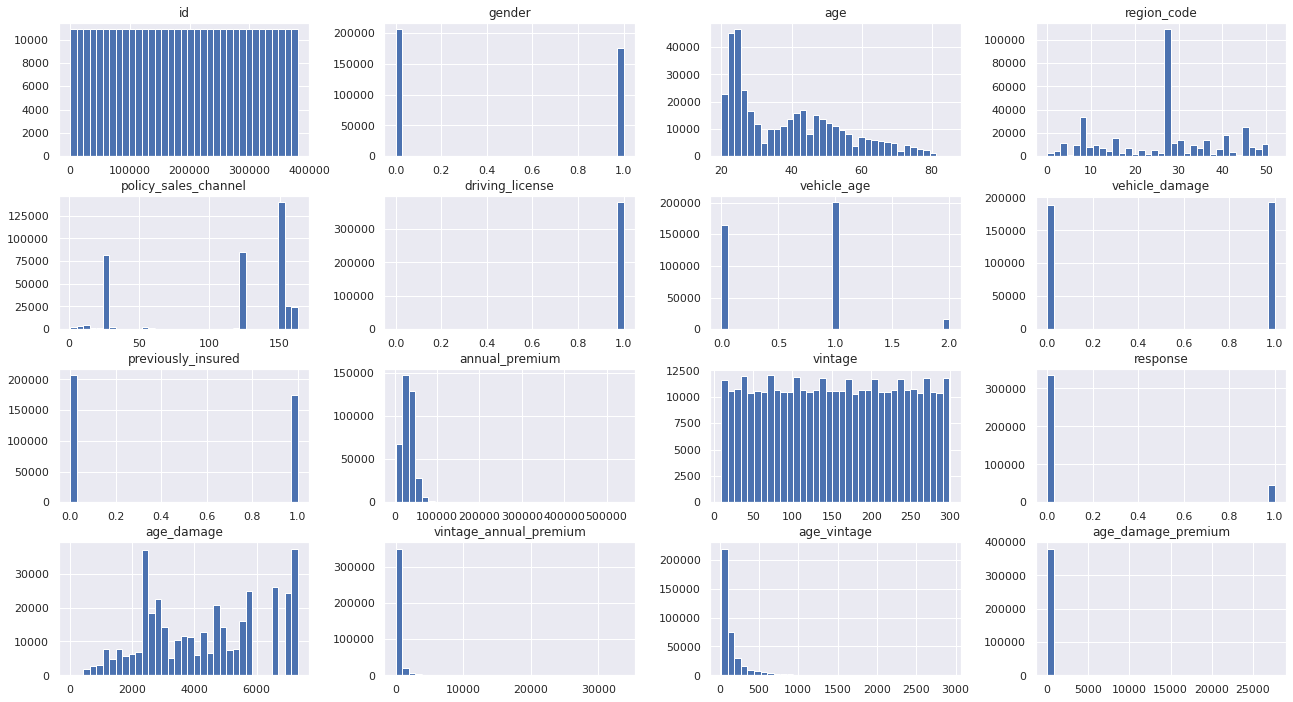

In [10]:
df3.hist(bins=35, figsize=(22,12));

In [83]:
aux = df3[['age', 'annual_premium', 'vintage', 'age_damage', 'vintage_annual_premium', 'age_vintage', 'age_damage_premium']]
descriptive(aux)

,attributes,mean,median,mode,std,min,max,range,Q1,Q3,skewness,kurtosis
0,age,38.82258,36.00000,24.00000,15.51159,20.00000,85.00000,65.00000,25.00000,49.00000,0.67254,-0.56566
1,annual_premium,30564.38958,31669.00000,2630.00000,17213.13247,2630.00000,540165.00000,537535.00000,24405.00000,39400.00000,1.76609,34.00457
2,vintage,154.34740,154.00000,256.00000,83.67119,10.00000,299.00000,289.00000,82.00000,227.00000,0.00303,-1.20069
3,age_damage,4340.27836,4322.00000,6659.00000,1899.27119,2.00000,7324.00000,7322.00000,2600.00000,5845.00000,0.06601,-1.20221
4,vintage_annual_premium,363.74043,194.75234,15.20231,548.65240,8.79599,33717.28571,33708.48973,117.32028,374.18898,5.74146,107.70986
5,age_vintage,168.58202,91.87075,365.00000,230.41671,24.41472,2920.00000,2895.58528,56.47170,172.89474,4.11085,23.01507
6,age_damage_premium,10.61947,6.99411,0.39495,117.95895,0.35909,27663.00000,27662.64091,4.18640,11.65038,168.26877,33237.54538


### Response Variable

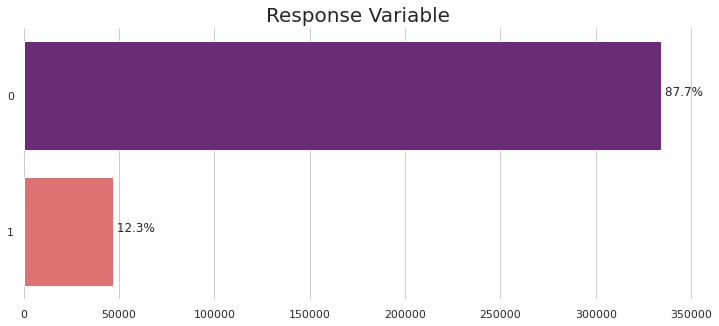

In [173]:
plt.figure(figsize=(12,5))
ax = sns.countplot(y='response', data=df3, palette='magma')
sns.set_style('whitegrid')
plt.title('Response Variable', size =20)
plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)
total = df3['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## Bivariate Analysis  (Hypothesis Test - Insight Generation)

### Hypothesis List

### H1 - Older customers are more likely to take out a car insurance
### H2 - Women are more likely to take out a car insurance 
### H3 - Customers with older cars are more likely to take out a car insurance
### H4 - Customers previously insured are more likely to take out a car insurance 
### H5 - Customers with previously damaged cars are more likely to take out a car insurance
### H6 - Customers with higher annual premium are more likely to take out a car insurance

## H1 - Older customers are more likely to take out a car insurance

#### False - People between 40 and 50 are more likely to take out a car insurance

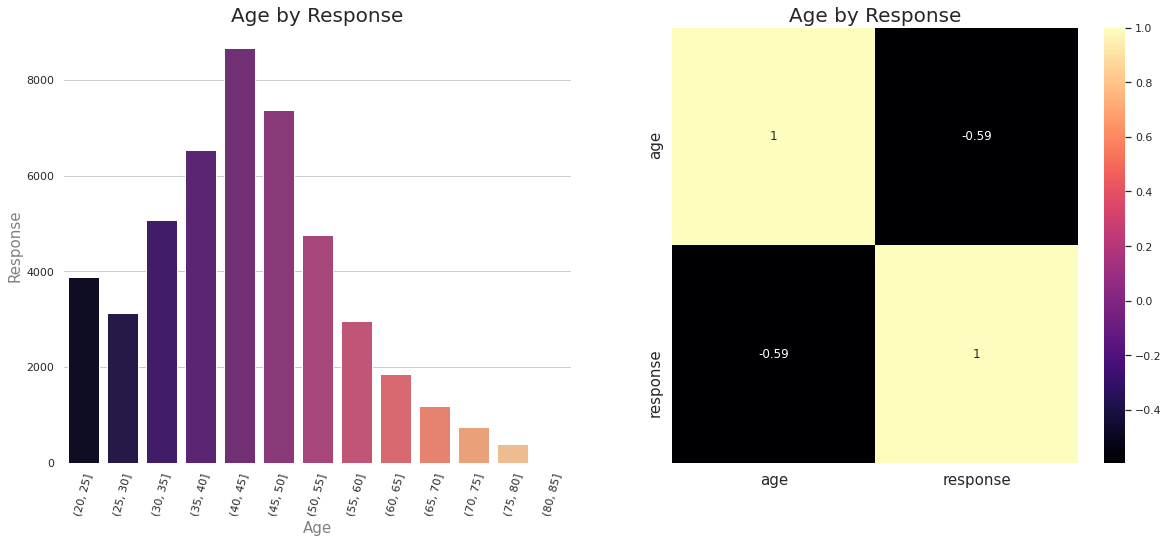

In [37]:
aux1 = df3[df3['response'] == 1 ][['response', 'age']].groupby(['age']).sum().reset_index()

bins = list( np.arange( 20, 90, 5) )
aux2 = aux1
aux2['age_bin'] = pd.cut(aux1['age'], bins=bins)
aux3 = aux2[['response', 'age_bin']].groupby(['age_bin']).sum().reset_index()

plt.figure(figsize(20,8))
plt.subplot(121)
sns.barplot(x='age_bin', y='response', data=aux3, palette='magma')
sns.despine(bottom=True, left=True)
sns.set_style('whitegrid')
plt.title('Age by Response', size=20)
plt.xlabel('Age', color='grey', size=15)
plt.ylabel('Response', color='grey', size=15);
plt.xticks(rotation=75)

plt.subplot(122)
sns.heatmap( aux2.corr( method='pearson' ), annot=True, cmap="magma" )
sns.despine( bottom = True, left = True)
plt.title( 'Age by Response', size=20)
plt.xticks(size = 15)
plt.yticks(size = 15);

## H2 - Women are more likely to take out a car insurance

#### False - Women are not more likely to take out a car insurance

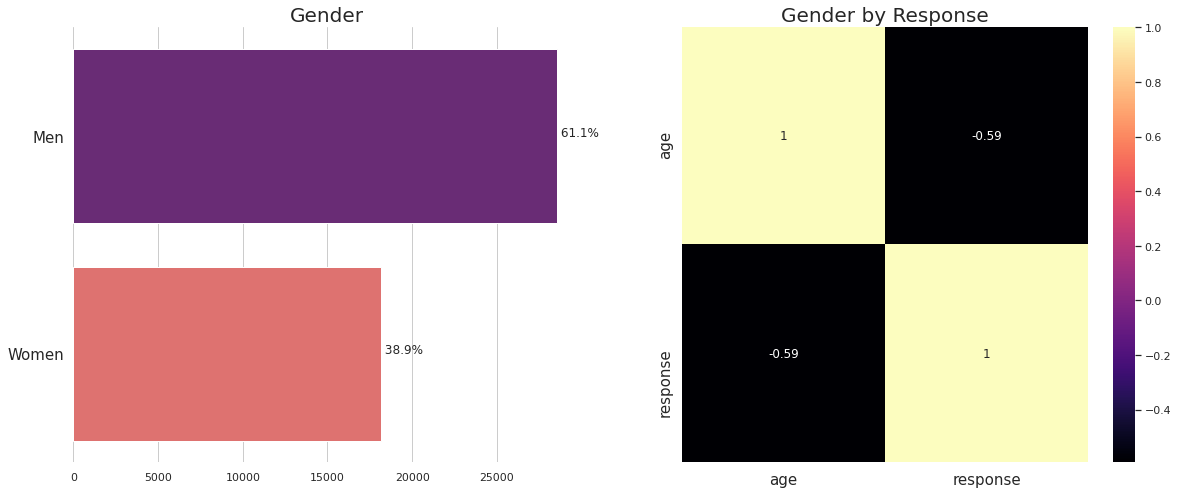

In [321]:
plt.figure(figsize(20,8))
plt.subplot(121)
aux1 = df3[df3['response'] == 1 ]

ax = sns.countplot(y='gender', data=aux1, palette='magma')
sns.set_style('whitegrid')
plt.title('Gender', size =20)
plt.yticks(np.arange(2), ['Men', 'Women'], size = 15)
plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)
total = aux1['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.subplot(122)
aux2= aux1[['response', 'age']].groupby(['age']).sum().reset_index()
sns.heatmap( aux2.corr( method='pearson' ), annot=True, cmap="magma")
sns.despine( bottom = True, left = True)
plt.title( 'Gender by Response', size=20)
plt.xticks(size = 15)
plt.yticks(size = 15);

## H3 - Customers with older cars are more likely to take out a car insurance

#### False - Customers with cars between 1 and 2 years are more likely to take out a car insurance

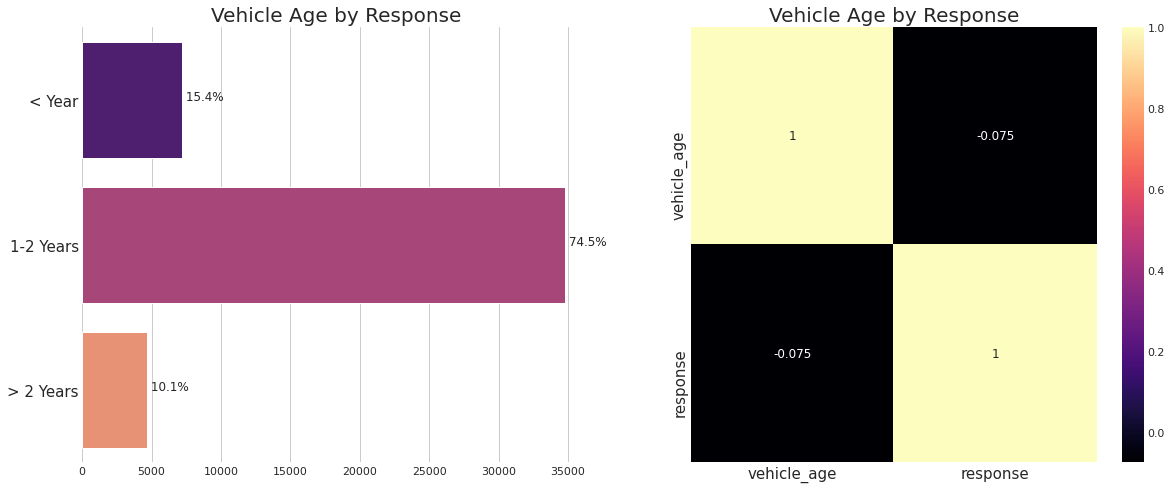

In [92]:
plt.figure(figsize(20,8))
plt.subplot(121)
aux1 = df3[df3['response'] == 1 ]

ax = sns.countplot(y='vehicle_age', data=aux1, palette='magma')
sns.set_style('whitegrid')
plt.title('Vehicle Age by Response', size=20)
plt.yticks(np.arange(3), ['< Year', '1-2 Years', '> 2 Years'], size = 15)
plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)
total = aux1['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
plt.subplot(122)
aux2= aux1[['response', 'vehicle_age']].groupby(['vehicle_age']).sum().reset_index()
sns.heatmap( aux2.corr( method='pearson' ), annot=True, cmap="magma")
sns.despine( bottom = True, left = True)
plt.title( 'Vehicle Age by Response', size=20)
plt.xticks(size = 15)
plt.yticks(size = 15);

## H4 - Customers previously insured are more likely to take out a car insurance

#### True - Customers previously insured are more likely to take out a car insurance

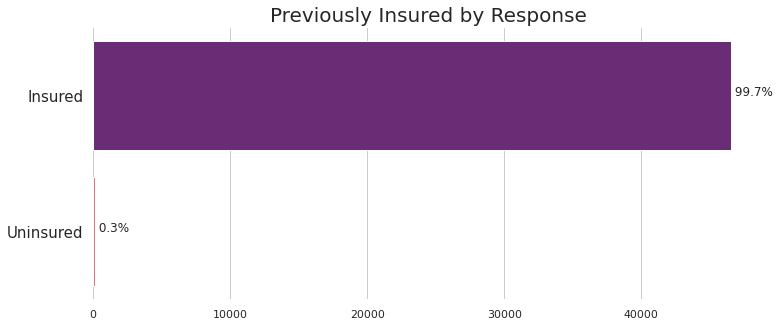

In [295]:
plt.figure(figsize=(12,5))
aux1 = df3[df3['response'] == 1 ]

ax = sns.countplot(y='previously_insured', data=aux1, palette='magma')
sns.set_style('whitegrid')
plt.title('Previously Insured by Response', size = 20)
plt.yticks(np.arange(2), ['Insured', 'Uninsured'], size = 15)
plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)
total = aux1['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## H5 - Customers with previously damaged cars are more likely to take out a car insurance

#### True - Customers with previously damaged cars are more likely to take out a car insurance

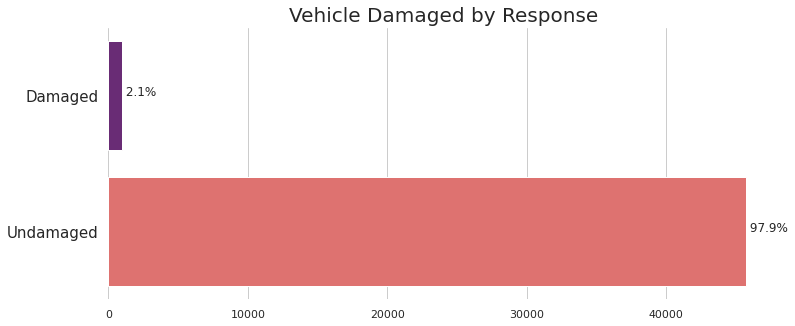

In [298]:
plt.figure(figsize=(12,5))
aux1 = df3[df3['response'] == 1 ]

ax = sns.countplot(y='vehicle_damage', data=aux1, palette='magma')
sns.set_style('whitegrid')
plt.title('Vehicle Damaged by Response', size = 20)
plt.yticks(np.arange(2), ['Damaged', 'Undamaged'], size = 15)
plt.xlabel('', color='white')
plt.ylabel('', color='white');
sns.despine( bottom=True, left=True)
total = aux1['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## H6 - Customers with higher annual premium are more likely to take out a car insurance

#### False - Customers with lower annual premium are more likely to take out a car insurance

In [ ]:
plt.figure(figsize(20,8))
plt.subplot(121)
sns.kdeplot(x='annual_premium', data=df3, hue='response', multiple="stack")
plt.title( 'Annual Premium by Response', size=20);

plt.subplot(122)
aux2= aux1[['response', 'annual_premium']].groupby(['annual_premium']).sum().reset_index()
sns.heatmap( aux2.corr( method='pearson' ), annot=True, cmap="magma")
sns.despine( bottom = True, left = True)
plt.title( 'Annual Premium by Response', size=20)
plt.xticks(size = 15)
plt.yticks(size = 15);

# Multivariate Analisys

## Pearson Correlation - Numeraical Features

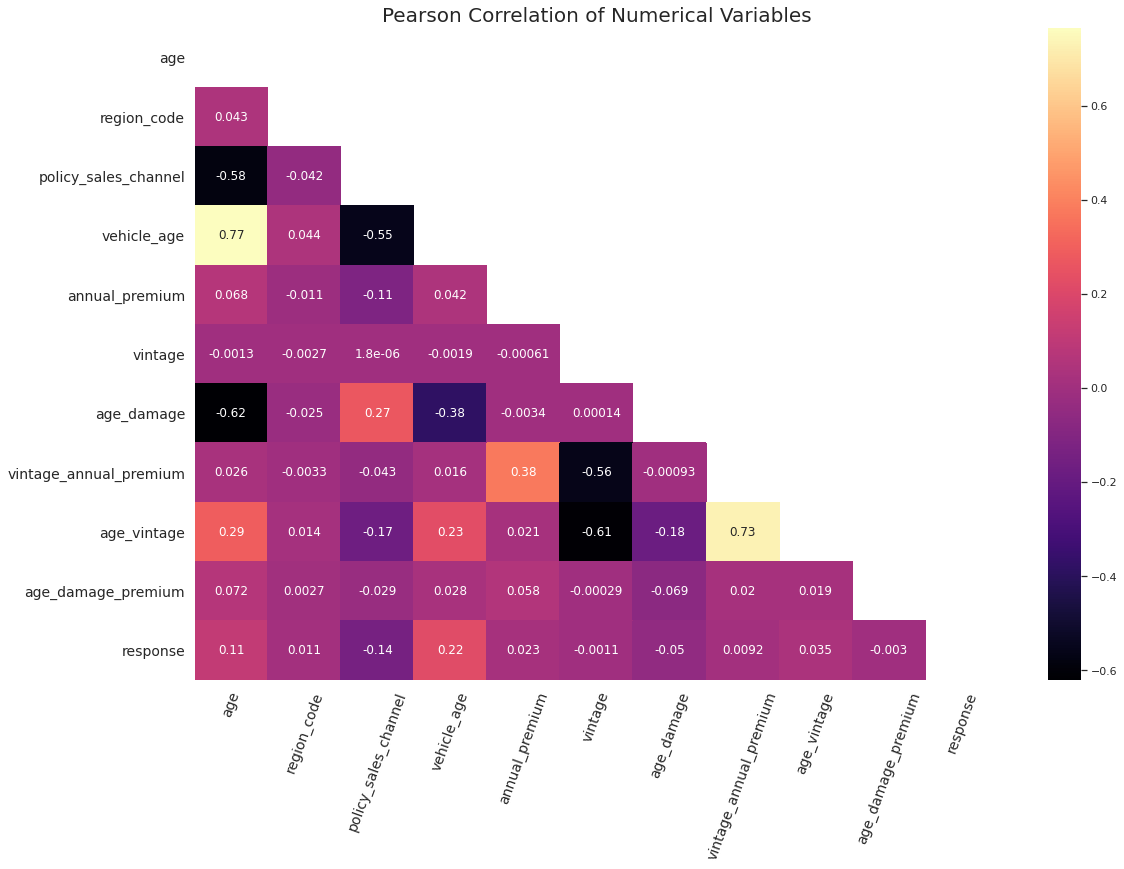

In [4]:
# correlation
corr = df3[['age', 'region_code', 'policy_sales_channel', 'vehicle_age', 
                   'annual_premium', 'vintage', 'age_damage', 'vintage_annual_premium',
                   'age_vintage', 'age_damage_premium', 'response']].corr(method='pearson')

# Creating a with mask for the superior triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    # Creating the chart with mask
    plt.figure(figsize(18,12))
    ax = sns.heatmap(corr, mask=mask, annot = True, cmap = 'magma')
    plt.xticks(size = 14, rotation=70)
    plt.yticks(size = 14)
    plt.title("Pearson Correlation of Numerical Variables", size=20);

## Cramer's V (Pandas Profiling)

In [ ]:
profile = ProfileReport(df3, title='Insurance All 2') 
profile.to_file(output_file='Insurance_All_2')

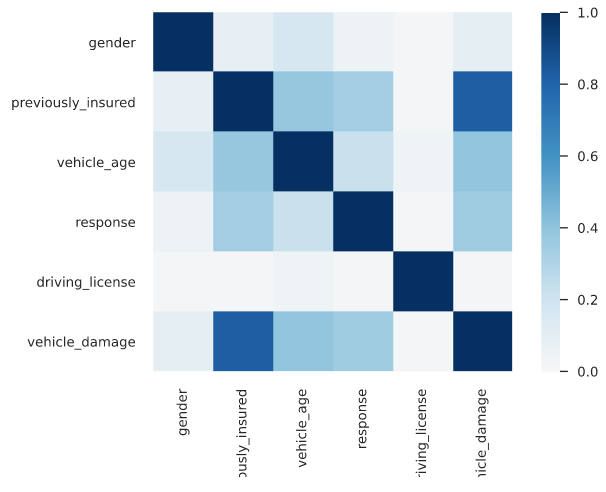

In [15]:
# Cramer's V
Image('img/cramer.png')

# Split into train (70%), validation (10%) and test (20%)

In [7]:
# load data
df4 = pickle.load(open('data/df2.pkl', 'rb'))

# select features and target variable
X = df4.drop(df4[['response', 'id']], axis=1)
y = df4['response'].copy()

# train test split
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28, stratify=y)

# train valid split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=28)

df4 = pd.concat([x_train, y_train], axis=1)

# check balance of classes (0, 1) among y_train, y_test and y_valid
print(f"y_train size: {np.bincount(y_train)}")
print(f"y_test size: {np.bincount(y_test)}")
print(f"y_valid size: {np.bincount(y_val)}")

y_train size: [240862  33536]
y_test size: [66880  9342]
y_valid size: [26657  3832]


In [8]:
# shape of trains, tests and vals
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(274398, 14)
(30489, 14)
(76222, 14)
(274398,)
(30489,)
(76222,)


In [9]:
x_train.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,age_damage,vintage_annual_premium,age_vintage,age_damage_premium
141596,0,43,12.00000,26.00000,1,1,0,0,63213.00000,47,5845,1344.95745,333.93617,10.81488
329574,0,79,28.00000,26.00000,1,1,1,0,47549.00000,290,554,163.96207,99.43103,85.82852
352039,1,25,36.00000,152.00000,1,0,1,0,41832.00000,95,4791,440.33684,96.05263,8.73137
33029,0,41,46.00000,124.00000,1,1,0,1,26001.00000,36,5253,722.25000,415.69444,4.94974
35845,1,22,25.00000,152.00000,1,0,0,1,25372.00000,279,7141,90.93907,28.78136,3.55300


In [10]:
# saving all data
pickle.dump(x_train, open('data/x_train.pkl', 'wb'))
pickle.dump(x_test, open('data/x_test.pkl', 'wb'))
pickle.dump(x_val, open('data/x_valy_val.pkl', 'wb'))

pickle.dump(y_train, open('data/y_train.pkl', 'wb'))
pickle.dump(y_test, open('data/y_test.pkl', 'wb'))
pickle.dump(y_val, open('data/y_val.pkl', 'wb'))

pickle.dump(df4, open('data/df4.pkl', 'wb'))

# Data Preparation

## Reescaling

In [11]:
df5 = pickle.load(open('data/df4.pkl', 'rb'))

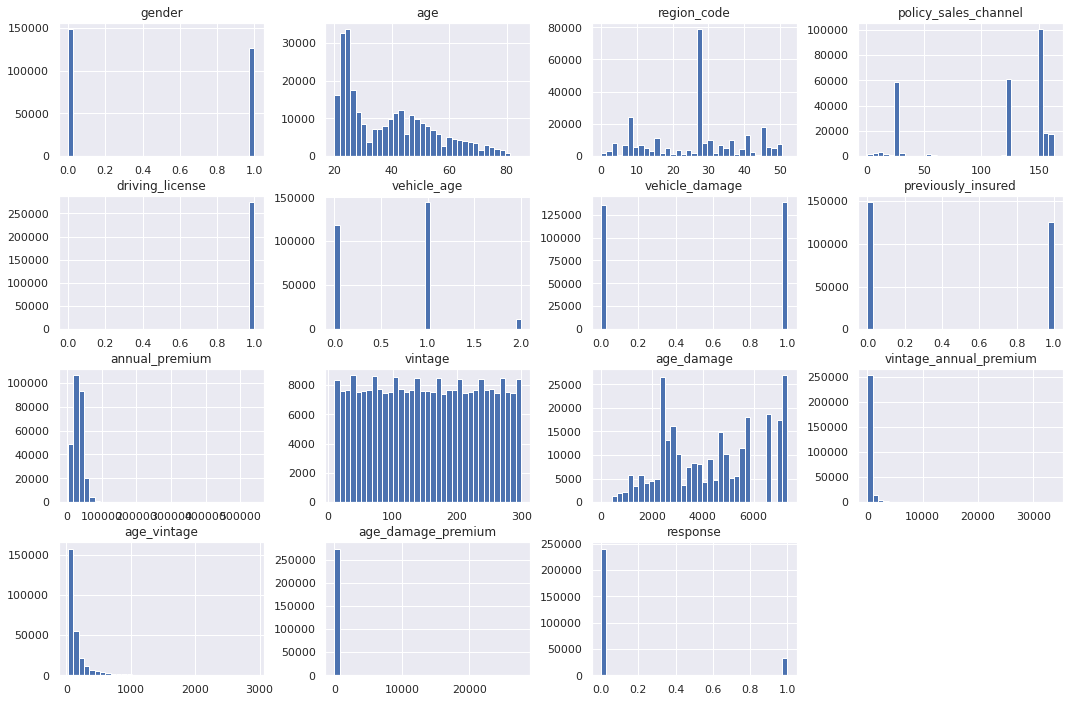

In [12]:
df5.hist(bins=35, figsize=(18,12));

In [13]:
# scalers
ss = StandardScaler()
rs = RobustScaler()
mms = MinMaxScaler()

# age - min-max
df5['age'] = mms.fit_transform( df5[['age']].values )

# annual premium - robust
df5['annual_premium'] = rs.fit_transform( df5[['annual_premium']].values )

# age damage - min-max 
df5['age_damage'] = mms.fit_transform( df5[['age_damage']].values )

# vintage annual premium - robust
df5['vintage_annual_premium'] = rs.fit_transform( df5[['vintage_annual_premium']].values )

# age vintage - robust
df5['age_vintage'] = rs.fit_transform( df5[['age_vintage']].values )

# age damage premium - robust
df5['age_damage_premium'] = rs.fit_transform( df5[['age_damage_premium']].values )

# saving for future deploy
mms_age = mms
rs_annual_premium = rs 
mms_age_damage = mms 
rs_vintage_annual_premium = rs
rs_age_vintage = rs
rs_age_damage_premium = rs 

## Validation Preparation

In [14]:
# age
x_val.loc[:,'age'] = mms_age.transform(x_val[['age']].values)

# annual premium
x_val.loc[:,'annual_premium'] = rs_annual_premium.transform(x_val[['annual_premium']].values)

# age damage
x_val.loc[:,'age_damage'] = mms_age_damage.transform(x_val[['age_damage']].values)

# vintage annual premium
x_val.loc[:,'vintage_annual_premium'] = rs_vintage_annual_premium.transform(x_val[['vintage_annual_premium']].values)

# age vintage
x_val.loc[:,'age_vintage'] = rs_age_vintage.transform(x_val[['age_vintage']].values)

# age damage premium
x_val.loc[:,'age_damage_premium'] = rs_age_damage_premium.transform(x_val[['age_damage_premium']].values)

In [15]:
pickle.dump(df5, open('data/df5.pkl', 'wb'))
pickle.dump(x_val, open('data/x_val.pkl', 'wb'))

# Balancing

In [16]:
# load data
df5 = pickle.load(open('data/df5.pkl', 'rb'))
x_val = pickle.load(open('data/x_val.pkl', 'rb'))
y_val = pickle.load(open('data/y_val.pkl', 'rb'))
x_train = df5.drop(['response'], axis=1).copy()
y_train = df5['response'].copy()

In [17]:
# check y_train
y_train.value_counts()

0    240862
1     33536
Name: response, dtype: int64

In [18]:
# ratio
ratio= {0: 240862,
        1: 7*33536}

smt=SMOTETomek(sampling_strategy=ratio, random_state=28, n_jobs=-1)

# apply sampler
x_train, y_train=smt.fit_resample(x_train, y_train)

In [19]:
# check y_train
y_train.value_counts()

0    237376
1    231266
Name: response, dtype: int64

In [20]:
# check y_val
y_val.value_counts()

0    26657
1     3832
Name: response, dtype: int64

In [21]:
# ratio
ratio= {0: 26657,
        1: 6*3832}

smt=SMOTETomek(sampling_strategy=ratio, random_state=28, n_jobs=-1)

# apply sampler
x_val, y_val=smt.fit_resample(x_val, y_val)

In [22]:
# check y_val
y_val.value_counts()

0    25709
1    22044
Name: response, dtype: int64

In [23]:
# save
pickle.dump(x_train, open('data/x_train.pkl', 'wb'))
pickle.dump(x_val, open('data/x_val.pkl', 'wb'))
pickle.dump(y_train, open('data/y_train.pkl', 'wb'))
pickle.dump(y_val, open('data/y_val.pkl', 'wb'))

# Feature Selection

In [24]:
# load data
x_train = pickle.load(open('data/x_train.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))

## Random Forest 

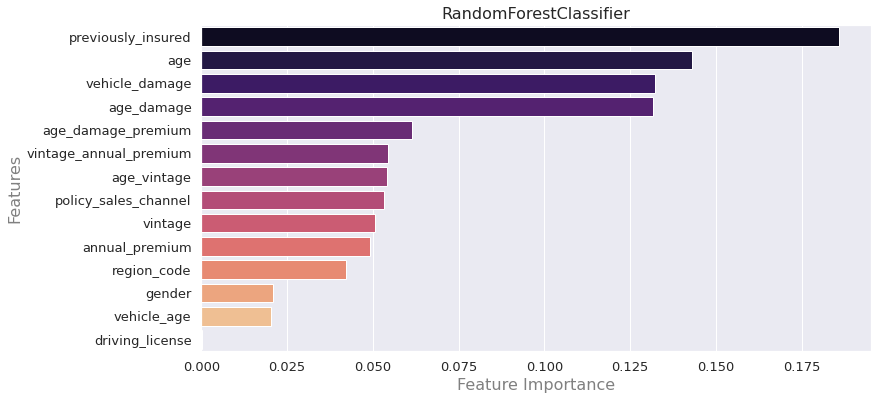

In [25]:
# classifier
rf = RandomForestClassifier(n_jobs=-1)
feature_selection(rf, x_train, y_train)

### Based on the EDA and Random Forest It will be used the criterion of 0.06 for feature selection:

- ['previously_insured',
- 'age',
- 'age_damage',
- 'vehicle_damage',
- 'age_damage_premium',
- 'age_vintage',
- 'vintage_annual_premium', 
- 'policy_sales_channel', 
- 'vintage']

# Machine Learning

In [26]:
# load data
x_train = pickle.load(open('data/x_train.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))
x_val = pickle.load(open('data/x_val.pkl', 'rb'))
y_val = pickle.load(open('data/y_val.pkl', 'rb'))
df6 = pickle.load(open('data/df5.pkl', 'rb'))

In [28]:
# select features from feature selection
x_train = x_train[['previously_insured',
                   'age',
                   'age_damage',
                   'vehicle_damage',
                   'age_damage_premium',
                   'age_vintage',
                   'vintage_annual_premium',
                   'policy_sales_channel', 
                   'vintage']].copy()

# select features from feature selection
x_val = x_val[['previously_insured',
               'age',
               'age_damage',
               'vehicle_damage',
               'age_damage_premium',
               'age_vintage',
               'vintage_annual_premium', 
               'policy_sales_channel', 
               'vintage']].copy()


In [29]:
model=[CatBoostClassifier(random_state=28, verbose=False),
       XGBClassifier(random_state=28, verbosity=0),
       LGBMClassifier(random_state=28, n_jobs=-1),
       LogisticRegression(max_iter=220, random_state=28),
       RandomForestClassifier(random_state=28),
       ExtraTreesClassifier(random_state=28),
       BalancedRandomForestClassifier(random_state=28),
       KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
       SGDClassifier(loss='log', random_state=28, n_jobs=-1), 
       GaussianNB(),
       DummyClassifier()]

metrics_at_k(df6, model, x_train, y_train, x_val, y_val)

Training CatBoostClassifier...
Training XGBClassifier...
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training ExtraTreesClassifier...
Training BalancedRandomForestClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training GaussianNB...
Training DummyClassifier...


,Model Name,Precision@K,Recall@K
0,LGBMClassifier,0.84911,0.77041
0,XGBClassifier,0.81846,0.74261
0,RandomForestClassifier,0.76706,0.69597
0,DummyClassifier,0.75981,0.68939
0,CatBoostClassifier,0.72536,0.65814
0,BalancedRandomForestClassifier,0.71951,0.65283
0,ExtraTreesClassifier,0.70511,0.63977
0,LogisticRegression,0.68592,0.62235
0,SGDClassifier,0.68342,0.62008
0,GaussianNB,0.66902,0.60701


## KNN

In [30]:
# fit model
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# probabilities prediction
yhat_knn = knn.predict_proba(x_val)[:,1]

# top k accuracy
print('Accuracy@K:' '{:.5f}'.format(top_k_accuracy_score(y_val, yhat_knn, k=1)))

Accuracy@K:0.56568


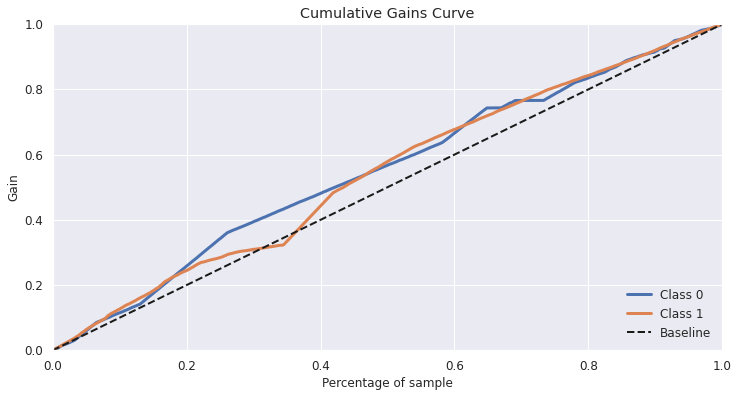

In [31]:
# Cumulative Gain
yhat_knn = knn.predict_proba(x_val)
plot_cumulative_gain(y_val, yhat_knn);

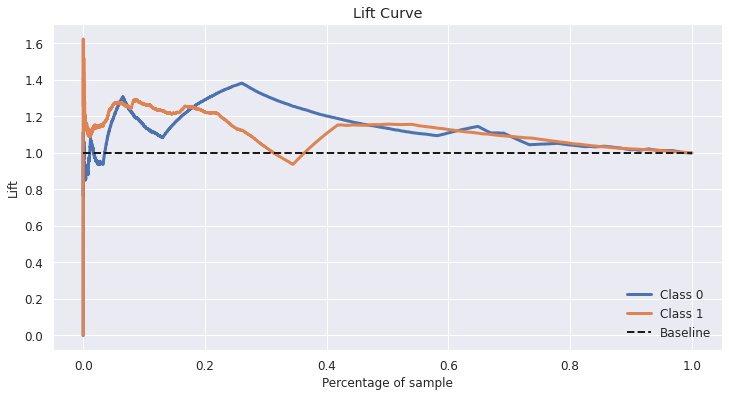

In [32]:
# Lift Curve
yhat_knn = knn.predict_proba(x_val)
plot_lift_curve(y_val, yhat_knn);

## LGBM

In [33]:
# lgbm
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)

# probabilities prediction
yhat_lgbm = lgbm.predict_proba(x_val)[:,1]

# top k accuracy
print('Accuracy@K:' '{:.5f}'.format(top_k_accuracy_score(y_val, yhat_lgbm, k=1)))

Accuracy@K:0.76475


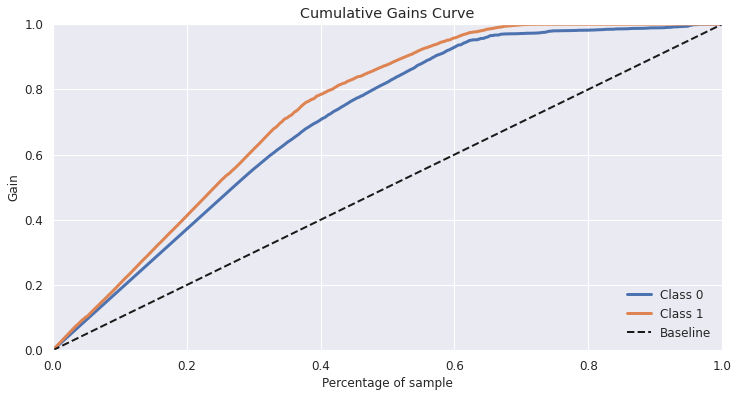

In [34]:
# Cumulative Gain
yhat_lgbm = lgbm.predict_proba(x_val)
plot_cumulative_gain(y_val, yhat_lgbm);

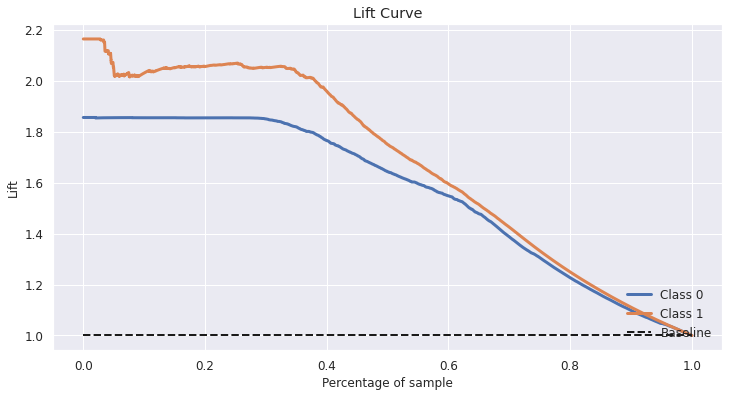

In [35]:
# Lift Curve
yhat_lgbm = lgbm.predict_proba(x_val)
plot_lift_curve( y_val, yhat_lgbm );

## Balanced Random Forest

In [36]:
# fit model
brf = BalancedRandomForestClassifier()
brf.fit(x_train, y_train)

# probabilities prediction
yhat_brf = brf.predict_proba(x_val)[:,1]

# top k accuracy
print('Accuracy@K:' '{:.5f}'.format(top_k_accuracy_score(y_val, yhat_brf, k=1)))

Accuracy@K:0.76274


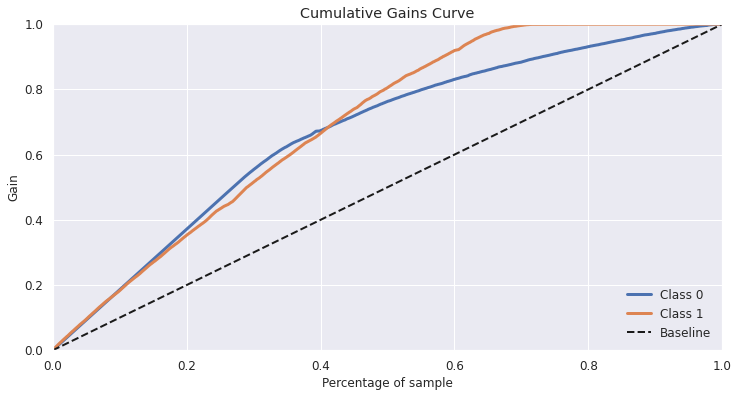

In [37]:
# Cumulative Gain
yhat_brf = brf.predict_proba(x_val)
plot_cumulative_gain(y_val, yhat_brf);

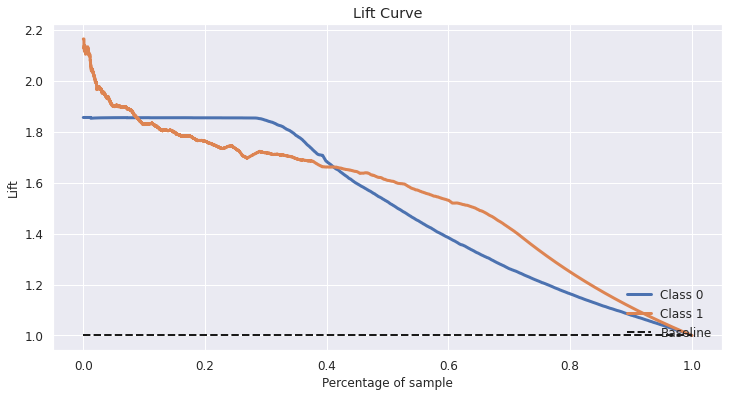

In [38]:
# Lift Curve
yhat_brf = brf.predict_proba(x_val)
plot_lift_curve(y_val, yhat_brf);

## Random Forest

In [39]:
# fit model
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# probabilities prediction
yhat_rf = rf.predict_proba(x_val)[:,1]

# top k accuracy
print('Accuracy@K:' '{:.5f}'.format(top_k_accuracy_score(y_val, yhat_rf, k=1)))

Accuracy@K:0.76406


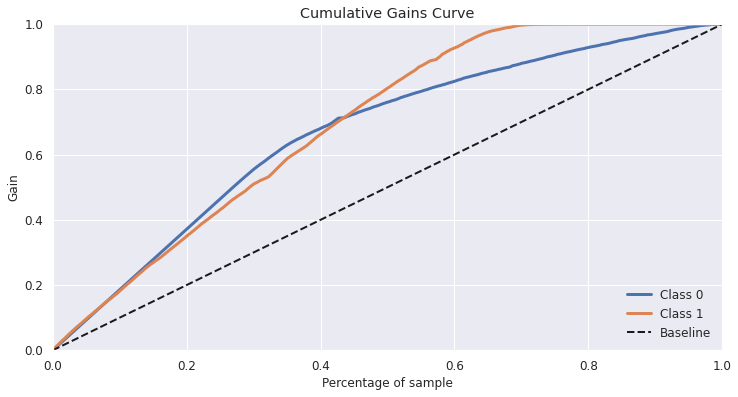

In [40]:
# Cumulative Gain
yhat_rf = rf.predict_proba(x_val)
plot_cumulative_gain(y_val, yhat_rf);

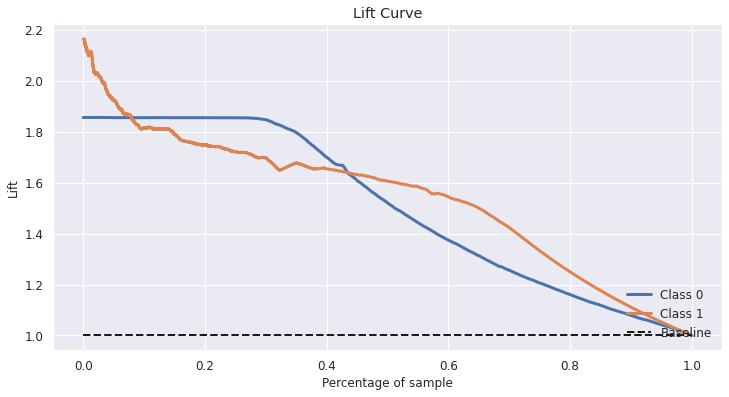

In [41]:
# Lift Curve
yhat_rf = rf.predict_proba(x_val)
plot_lift_curve(y_val, yhat_rf);